# PDF Loader for Neo4j GraphRAG

This notebook loads PDF files into a Neo4j knowledge graph using the GraphRAG pipeline. It demonstrates loading company filings, extracting entities and relationships, and creating a vector index for semantic search.

> **Prerequisites:**  
> - Ensure you have filled out the `.env` file with your Neo4j and OpenAI credentials.  
> - Install all dependencies with `pip install -r requirements.txt`.  
> - Place your data files in the `data/` directory as described below.

## Imports and Environment Setup

This cell imports all necessary libraries and modules for the PDF loader pipeline:
- `neo4j`, `neo4j_graphrag`: For connecting to Neo4j and using the GraphRAG pipeline.
- `dotenv`, `os`: For loading environment variables and managing system paths.
- `time`, `asyncio`: For controlling execution timing and running asynchronous tasks.

In [ ]:
%pip install -r requirements.txt

In [ ]:
# --- Imports and Environment Setup ---
from neo4j import GraphDatabase
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.generation.prompts import ERExtractionTemplate
from dotenv import load_dotenv
import os
import time
import asyncio
import glob
import csv

## Load Environment Variables and Connect to Neo4j

This cell loads environment variables required for connecting to Neo4j and OpenAI. It uses `python-dotenv` to securely access credentials from a `.env` file, and then establishes a connection to the Neo4j database using the provided URI, username, and password.

- `NEO4J_URI`, `NEO4J_USER`, `NEO4J_PASSWORD`: Used for Neo4j database authentication.

In [ ]:
# --- Load Environment Variables ---
import neo4j


load_dotenv()
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

print("Using OpenAI cloud backend")
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

NEO4J_URI

## Documents and Chunks in the Pipeline

**Documents** are the original files (e.g., PDFs) ingested by the pipeline. Each document typically represents a complete source, such as a company filing or report.

**Chunks** are smaller, semantically meaningful segments of text extracted from each document. Chunking is crucial for:
- Improving retrieval and search accuracy.
- Enabling the language model to process long documents by breaking them into manageable pieces.
- Storing embeddings for each chunk, allowing for efficient similarity search within Neo4j.

During processing:
- Each PDF is split into chunks using a text splitter (e.g., LangChain's RecursiveCharacterTextSplitter).
- Each chunk is embedded and stored as a node in the Neo4j graph, linked to its parent document node.
- This structure supports both granular semantic search and traceability back to the original document.

This approach ensures that the knowledge graph is both scalable and highly searchable at the level of individual concepts or facts.

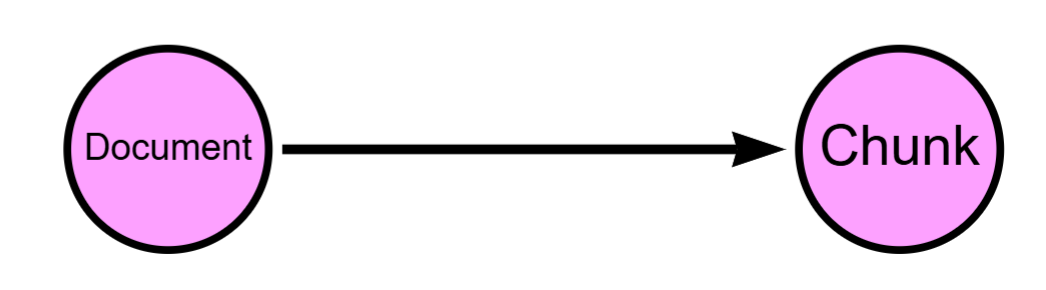

> **Why Chunking?**  
>
> Chunking splits long documents into smaller, semantically meaningful pieces.  
>
> This improves retrieval accuracy and enables efficient semantic search in Neo4j, as each chunk becomes a searchable unit linked to its source document.

## Load Approved Company Names

This cell loads a list of approved company names from `data/Company_Filings.csv`. Only companies in this list will be considered during information extraction.

- Reads the CSV file containing company names.
- Adds each company name (converted to uppercase and stripped of whitespace) to the `approved_companies` set.
- This ensures that only explicitly approved companies are processed in later steps.

In [ ]:
# --- Load Approved Company Names ---
approved_companies = set()
with open('data/Company_Filings.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        name = row.get('name')
        if name:
            approved_companies.add(name.strip().upper())
approved_companies

## Initialize LLM and Embeddings

This cell sets up the language model (LLM) and embedding model required for semantic extraction and vector search:

- `OpenAILLM`: Initializes the OpenAI language model (e.g., GPT-3.5-turbo) for entity and relationship extraction.
- `OpenAIEmbeddings`: Sets up the embedding model to convert text into vector representations for similarity search in Neo4j.
- The `api_key` is securely loaded from environment variables.
- The `dimensions` parameter specifies the embedding vector size (1536 for OpenAI models).

In [ ]:
# --- Initialize LLM and Embeddings ---
llm = OpenAILLM(
    model_name="gpt-4o",
    api_key=OPENAI_API_KEY
)
dimensions = 1536
embedder = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

## Define Node Labels and Relationship Types

This cell specifies the schema for the knowledge graph:

- **Entities:** Lists all node types (e.g., Executive, Product, FinancialMetric, Company) and their properties.
- **Relations:** Defines the allowed relationships between entities (e.g., HAS_METRIC, FACES_RISK, ISSUED_STOCK, MENTIONS).
- This schema is passed to the pipeline to enforce structure and ensure consistent graph construction.
- The `print` statements allow you to verify the entity definitions before running the pipeline.

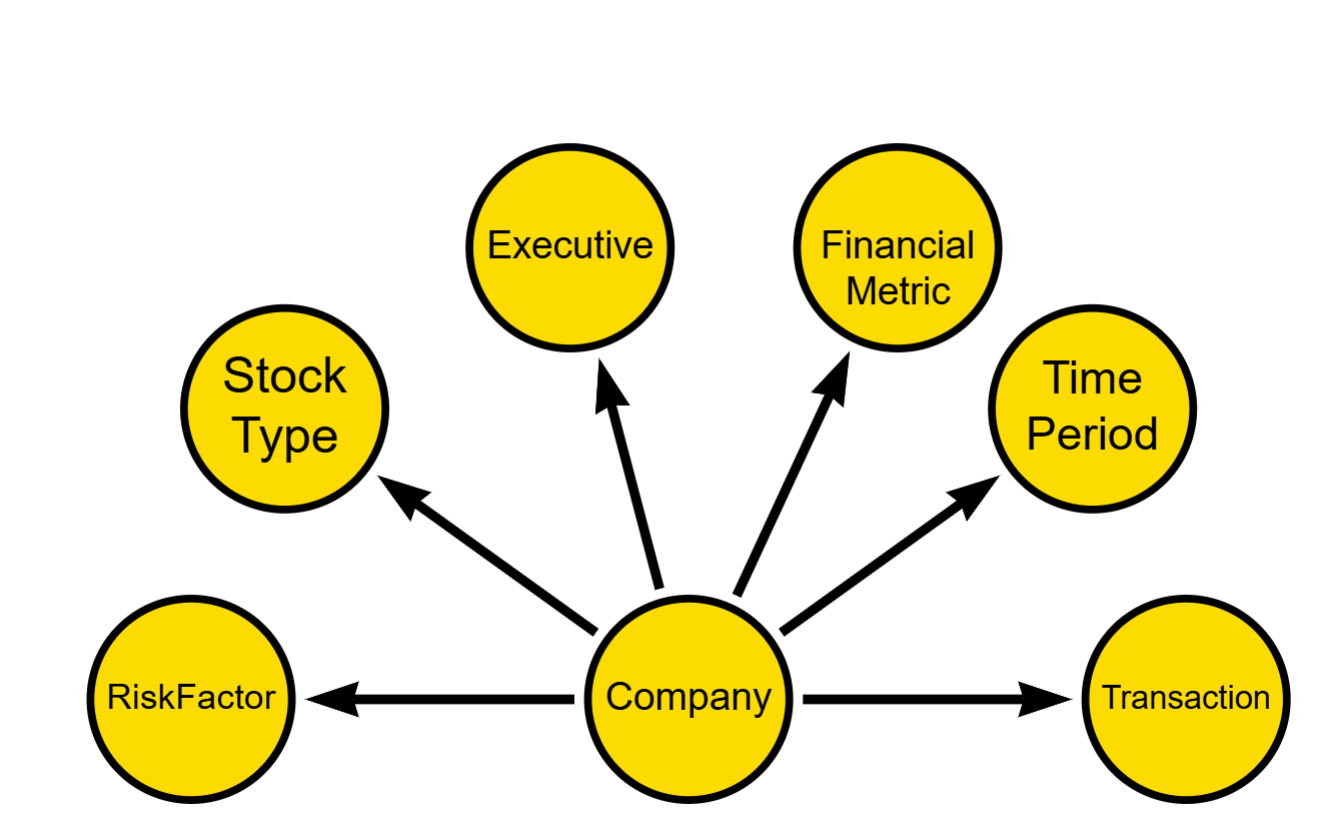


In [ ]:
# --- Define Node Labels and Relationship Types ---
entities = [
    {"label": "Executive", "properties": [{"name": "name", "type": "STRING"}]},
    {"label": "Product", "properties": [{"name": "name", "type": "STRING"}]},
    {"label": "FinancialMetric", "properties": [{"name": "name", "type": "STRING"}]},
    {"label": "RiskFactor", "properties": [{"name": "name", "type": "STRING"}]},
    {"label": "StockType", "properties": [{"name": "name", "type": "STRING"}]},
    {"label": "Transaction", "properties": [{"name": "name", "type": "STRING"}]},
    {"label": "TimePeriod", "properties": [{"name": "name", "type": "STRING"}]},
    {"label": "Company", "properties": [{"name": "name", "type": "STRING"}]}
]
relations = [
    {"label": "HAS_METRIC", "source": "Company", "target": "FinancialMetric"},
    {"label": "FACES_RISK", "source": "Company", "target": "RiskFactor"},
    {"label": "ISSUED_STOCK", "source": "Company", "target": "StockType"},
    {"label": "MENTIONS", "source": "Company", "target": "Product"}  # Adjust as needed
]

## Establish the Prompt Template

This cell constructs the prompt template that guides the language model (LLM) during entity and relationship extraction:

- The prompt strictly instructs the LLM to extract information only about companies from the approved list, using their exact names.
- It explains how to handle ambiguous references (e.g., "the Company", "the Registrant") by requiring the model to resolve these to an allowed company name based on context.
- The approved company names are dynamically included in the prompt for clarity and enforcement.
- The template is combined with the default extraction instructions from the GraphRAG library, ensuring consistent and accurate extraction behavior.

This approach helps ensure that only relevant, properly-named entities are extracted into the knowledge graph.

In [ ]:
# --- Establish Prompt Template for KG Builder ---
joined_names = '\n'.join(f'- {name}' for name in approved_companies)

company_instruction = (
    "Extract only information about the following companies. "
    "If a company is mentioned but is not in this list, ignore it. "
    "When extracting, the company name must match exactly as shown below. "
    "Do not generate or include any company not on this list or an alternate name for any company on this list. "
    "ONLY USE THE COMPANY NAME EXACTLY AS SHOWN IN THE LIST. "
    "If the text refers to 'the Company', 'the Registrant', or uses a pronoun or generic phrase instead of a company name, "
    "you MUST look up and use the exact company name from the allowed list based on context (such as the file being processed). "
    "UNDER NO CIRCUMSTANCES should you output 'the Company', 'the Registrant', or any generic phrase as a company name. "
    "Only use the exact allowed company name.\n\n"
    f"Allowed Companies (match exactly):\n{joined_names}\n\n"
)

custom_template = company_instruction + ERExtractionTemplate.DEFAULT_TEMPLATE
prompt_template = ERExtractionTemplate(template=custom_template)

## Initialize and Run the Knowledge Graph Pipeline

This cell creates an instance of the `SimpleKGPipeline` using the Neo4j driver, language model, embedder, entities, relations, and prompt template.

- The pipeline enforces the schema strictly, ensuring only the defined entities and relationships are created.
- If initialization fails (e.g., due to a misconfiguration or connection issue), an error message is printed and the exception is raised.
- This is a critical step for setting up the end-to-end PDF-to-graph workflow.

In [ ]:
# --- Initialize and Run the Pipeline ---
try:
    pipeline = SimpleKGPipeline(
        driver=driver,
        llm=llm,
        embedder=embedder,
        entities=entities,
        relations=relations,
        prompt_template=prompt_template,
        enforce_schema="STRICT"
    )
except Exception as e:
    print("Pipeline initialization failed:", e)
    raise

## Define Async Pipeline Runner

This cell defines an asynchronous function to run the extraction pipeline on a single PDF file.

- The function `run_pipeline_on_file` takes a file path and the pipeline as arguments.
- It calls the pipeline's async method to process the file.
- This setup allows for non-blocking, scalable processing of multiple PDF files.

In [ ]:
# --- Async Pipeline Run Example ---
async def run_pipeline_on_file(file_path, pipeline):
    await pipeline.run_async(file_path=file_path)

## Run the Pipeline on All PDF Files (Notebook-Friendly Async)

This cell processes each PDF file in the target directory using the extraction pipeline, adapted for Jupyter notebooks:

- Uses `nest_asyncio` to allow running asynchronous code within Jupyter's existing event loop.
- Calls the async pipeline runner with `await` for each file, ensuring proper coroutine execution.
- Adds a delay (`time.sleep(21)`) between requests to respect OpenAI's rate limits.
- Handles and prints errors for individual files, continuing with the next one.
- Prints a completion message when all files are processed.

This approach avoids `asyncio.run()` errors in notebook environments and ensures robust batch processing.

In [ ]:
pdf_files = ['data/form10k-sample/' + file for file in os.listdir('data/form10k-sample') if file.endswith('.pdf')]
pdf_files

In [ ]:
import nest_asyncio

nest_asyncio.apply()

for pdf_file in pdf_files:
    print(pdf_file)
    try:
        await run_pipeline_on_file(pdf_file, pipeline)
        time.sleep(21)
    except Exception as e:
        print(f"Error processing {pdf_file}: {str(e)}")
        print("Continuing with next file...")
        continue

## Create Vector Index in Neo4j

This cell creates a vector index on the `embedding` property of `RiskFactor` nodes in Neo4j.

- The vector index enables efficient similarity search over embedded chunk vectors using cosine similarity.
- The index is configured for 1536-dimensional vectors, matching the output size of OpenAI embeddings.
- If the index already exists, the code will catch the exception and print a message.
- This step is essential for enabling semantic search and retrieval-augmented generation (RAG) workflows in Neo4j.

In [ ]:
# --- Create Vector Index in Neo4j ---
from neo4j_graphrag.indexes import create_vector_index

create_vector_index(driver, name="chunkEmbeddings", label="Chunk",
                    embedding_property="embedding", dimensions=1536, similarity_fn="cosine")